In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import integrate
import geopy.distance


import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [2]:
df_sample_data = pd.read_csv('data/Sample_data1.csv')
df_sample_data.head()

,fa_flight_id,altitude,altitude_change,groundspeed,heading,latitude,longitude,timestamp,update_type
0,TLM116-1664732580-schedule-0836,7,C,168,209,13.89892,100.59713,2022-10-04T17:23:06Z,A
1,TLM116-1664732580-schedule-0836,11,C,184,209,13.88681,100.59015,2022-10-04T17:23:22Z,A
2,TLM116-1664732580-schedule-0836,17,C,183,209,13.87550,100.58374,2022-10-04T17:23:38Z,A
3,TLM116-1664732580-schedule-0836,21,C,198,247,13.86586,100.57333,2022-10-04T17:23:54Z,A
4,TLM116-1664732580-schedule-0836,24,C,220,259,13.86200,100.55725,2022-10-04T17:24:10Z,A


In [3]:
npd = pd.read_csv('data/ANP2.2_NPD_data.csv',delimiter=';')
npd.head()

,NPD_ID,Noise Metric,Op Mode,Power Setting,L_200ft,L_400ft,L_630ft,L_1000ft,L_2000ft,L_4000ft,L_6300ft,L_10000ft,L_16000ft,L_25000ft
0,2CF650,EPNL,A,10000.0,106.2,101.1,97.2,92.5,84.2,75.0,68.0,61.4,53.4,43.3
1,2CF650,EPNL,A,25000.0,109.8,105.1,101.5,97.3,90.3,82.0,76.0,70.0,62.7,53.9
2,2CF650,EPNL,D,25000.0,109.8,105.1,101.5,97.3,90.3,82.0,76.0,70.0,62.7,53.9
3,2CF650,EPNL,D,40000.0,113.0,108.6,105.2,101.5,95.6,88.2,83.1,77.5,70.8,63.3
4,2CF650,LAmax,A,10000.0,99.2,91.9,86.7,81.0,72.1,63.0,56.7,49.6,41.6,33.1


In [4]:
Aircraft = pd.read_csv('data/ANP2.2_Aircraft.csv',delimiter=';')
Aircraft = Aircraft[Aircraft['ACFT_ID'] == '737800']
Aircraft.head()

,ACFT_ID,Description,Engine Type,Number Of Engines,Weight Class,Owner Category,Max Gross Takeoff Weight (lb),Max Gross Landing Weight (lb),Max Landing Distance (ft),Max Sea Level Static Thrust (lb),Noise Chapter,NPD_ID,Power Parameter,Approach Spectral Class ID,Departure Spectral Class ID,Lateral Directivity Identifier
24,737800,Boeing 737-800 / CFM56-7B26,Jet,2,Large,Commercial,174200,146300,5435,26300,3,CF567B,CNT (lb),203,104,Wing


In [5]:
df_fix_point = pd.read_csv('data/ANP2.2_Default_fixed_point_profiles.csv',delimiter=';')
df_fix_point = df_fix_point[df_fix_point.ACFT_ID == "727200"]
df_fix_point = df_fix_point[df_fix_point['Stage Length'] == 1]
df_fix_point = df_fix_point.reset_index(drop=True)

df_fix_point

,ACFT_ID,Op Type,Profile_ID,Stage Length,Point Number,Distance (ft),Altitude AFE (ft),TAS (kt),Power Setting
0,727200,A,DEFAULT,1,1,-114487.0,6000.0,250.0,809.0
1,727200,A,DEFAULT,1,2,-57243.0,3000.0,142.0,4490.0
2,727200,A,DEFAULT,1,3,-28622.0,1500.0,142.0,4490.0
3,727200,A,DEFAULT,1,4,-19081.0,1000.0,142.0,4490.0
4,727200,A,DEFAULT,1,5,0.0,0.0,142.0,4490.0
5,727200,A,DEFAULT,1,6,406.0,0.0,142.0,4758.0
6,727200,A,DEFAULT,1,7,4060.0,0.0,30.0,1190.0
7,727200,D,DEFAULT,1,1,0.0,0.0,35.0,11895.0
8,727200,D,DEFAULT,1,2,5968.0,0.0,153.0,11895.0
9,727200,D,DEFAULT,1,3,13346.0,1000.0,153.0,11895.0


In [35]:
# df_sample_data_initial2 = pd.read_csv('data/df_sample_data_initial2.csv')
df_sample_data_initial2 = pd.read_csv('ONLY_TEST/AIQ311-1670716320-schedule-0614.csv')
df_sample_data_initial2.drop(columns=['Unnamed: 0'],inplace=True)
# df_sample_data_initial2.rename(columns={'Unnamed: 0':'timestamp'}, inplace=True)
# df_sample_data_initial2['timestamp'] = pd.to_datetime(df_sample_data_initial2['timestamp'])
df_sample_data_initial2.head()


,timestamp,fa_flight_id,altitude,groundspeed,heading,latitude,longitude
0,2022-12-12 23:47:44,AIQ311-1670716320-schedule-0614,2.000,167.0000,209.0000,13.903990,100.599830
1,2022-12-12 23:47:45,AIQ311-1670716320-schedule-0614,2.375,166.9375,208.9375,13.903303,100.599454
2,2022-12-12 23:47:46,AIQ311-1670716320-schedule-0614,2.750,166.8750,208.8750,13.902616,100.599078
3,2022-12-12 23:47:47,AIQ311-1670716320-schedule-0614,3.125,166.8125,208.8125,13.901929,100.598701
4,2022-12-12 23:47:48,AIQ311-1670716320-schedule-0614,3.500,166.7500,208.7500,13.901243,100.598325


In [7]:
df_sample_data_initial2.iloc[65:80]

,Unnamed: 0,timestamp,fa_flight_id,altitude,groundspeed,heading,latitude,longitude
65,65,2022-12-12 23:48:49,AIQ311-1670716320-schedule-0614,25.25,177.25,249.375,13.863278,100.567922
66,66,2022-12-12 23:48:50,AIQ311-1670716320-schedule-0614,25.50,177.50,249.750,13.863046,100.567135
67,67,2022-12-12 23:48:51,AIQ311-1670716320-schedule-0614,25.75,177.75,250.125,13.862814,100.566348
68,68,2022-12-12 23:48:52,AIQ311-1670716320-schedule-0614,26.00,178.00,250.500,13.862583,100.565560
69,69,2022-12-12 23:48:53,AIQ311-1670716320-schedule-0614,26.25,178.25,250.875,13.862351,100.564773
70,70,2022-12-12 23:48:54,AIQ311-1670716320-schedule-0614,26.50,178.50,251.250,13.862119,100.563985
71,71,2022-12-12 23:48:55,AIQ311-1670716320-schedule-0614,26.75,178.75,251.625,13.861887,100.563198
72,72,2022-12-12 23:48:56,AIQ311-1670716320-schedule-0614,27.00,179.00,252.000,13.861655,100.562410
73,73,2022-12-12 23:48:57,AIQ311-1670716320-schedule-0614,27.25,179.25,252.375,13.861423,100.561622
74,74,2022-12-12 23:48:58,AIQ311-1670716320-schedule-0614,27.50,179.50,252.750,13.861191,100.560835


In [8]:
df_sample_data3 = pd.read_csv('data/Sample_data3.csv')
df_sample_data3[df_sample_data3['altitude'].isna()]
# df_sample_data3

,Unnamed: 0,timestamp,fa_flight_id,altitude,groundspeed,heading,latitude,longitude,segment


# Power setting

## initial

In [9]:
df_fix_poit_initial = df_fix_point[df_fix_point['Op Type'] == "A"]
df_fix_poit_initial

,ACFT_ID,Op Type,Profile_ID,Stage Length,Point Number,Distance (ft),Altitude AFE (ft),TAS (kt),Power Setting
0,727200,A,DEFAULT,1,1,-114487.0,6000.0,250.0,809.0
1,727200,A,DEFAULT,1,2,-57243.0,3000.0,142.0,4490.0
2,727200,A,DEFAULT,1,3,-28622.0,1500.0,142.0,4490.0
3,727200,A,DEFAULT,1,4,-19081.0,1000.0,142.0,4490.0
4,727200,A,DEFAULT,1,5,0.0,0.0,142.0,4490.0
5,727200,A,DEFAULT,1,6,406.0,0.0,142.0,4758.0
6,727200,A,DEFAULT,1,7,4060.0,0.0,30.0,1190.0


In [10]:
df__tmp = df_fix_poit_initial.copy().groupby('TAS (kt)').max()
df__tmp = df__tmp.reindex(df__tmp.index.union(df_sample_data_initial2.groundspeed.unique()))
df__tmp = df__tmp.interpolate(method='index',limit_direction='both',limit=200)
df__tmp = df__tmp.reindex(df_sample_data_initial2.groundspeed.unique())
df__tmp.reset_index(drop=False, inplace=True)
df__tmp.rename(columns={'TAS (kt)':'groundspeed'}, inplace=True)
df__tmp = df__tmp[['groundspeed', 'Power Setting']]
# df__tmp.iloc[215:230]
df__tmp[df__tmp['Power Setting'].isna()]

,groundspeed,Power Setting


In [11]:
df_sample_data_initial2 = df_sample_data_initial2.merge(df__tmp, how='left', on='groundspeed')
df_sample_data_initial2.head()

,Unnamed: 0,timestamp,fa_flight_id,altitude,groundspeed,heading,latitude,longitude,Power Setting
0,0,2022-12-12 23:47:44,AIQ311-1670716320-schedule-0614,2.000,167.0000,209.0000,13.903990,100.599830,3843.879630
1,1,2022-12-12 23:47:45,AIQ311-1670716320-schedule-0614,2.375,166.9375,208.9375,13.903303,100.599454,3846.164931
2,2,2022-12-12 23:47:46,AIQ311-1670716320-schedule-0614,2.750,166.8750,208.8750,13.902616,100.599078,3848.450231
3,3,2022-12-12 23:47:47,AIQ311-1670716320-schedule-0614,3.125,166.8125,208.8125,13.901929,100.598701,3850.735532
4,4,2022-12-12 23:47:48,AIQ311-1670716320-schedule-0614,3.500,166.7500,208.7500,13.901243,100.598325,3853.020833


# L by power level

## initial

In [12]:
npd_initial = npd[npd['NPD_ID'] == 'CF567B']
npd_initial = npd_initial[npd_initial['Noise Metric'] == 'LAmax']
npd_initial = npd_initial[npd_initial['Op Mode'] == 'A']
npd_initial.set_index('Power Setting', inplace=True)
npd_initial

,NPD_ID,Noise Metric,Op Mode,L_200ft,L_400ft,L_630ft,L_1000ft,L_2000ft,L_4000ft,L_6300ft,L_10000ft,L_16000ft,L_25000ft
Power Setting,,,,,,,,,,,,,
3000.0,CF567B,LAmax,A,93.0,85.9,81.1,76.1,68.0,59.2,52.5,45.6,37.5,29.3
4000.0,CF567B,LAmax,A,93.6,86.5,81.7,76.6,68.7,59.9,53.4,46.6,37.8,29.7
5000.0,CF567B,LAmax,A,94.1,87.0,82.2,77.2,69.2,60.5,54.1,47.4,39.0,31.1
6000.0,CF567B,LAmax,A,94.6,87.5,82.7,77.6,69.7,61.1,54.7,48.1,40.4,32.9
7000.0,CF567B,LAmax,A,95.0,87.9,83.0,78.0,70.1,61.5,55.2,48.7,41.8,34.5


In [13]:
# df_sample_data_initial2['Power Setting'].unique()

In [14]:
npd_initial = npd_initial.reindex(npd_initial.index.union(df_sample_data_initial2['Power Setting'].unique()))
npd_initial = npd_initial.interpolate(method='index',limit_direction='both',limit=200)
npd_initial[npd_initial['L_4000ft'].isna()]
npd_initial

,NPD_ID,Noise Metric,Op Mode,L_200ft,L_400ft,L_630ft,L_1000ft,L_2000ft,L_4000ft,L_6300ft,L_10000ft,L_16000ft,L_25000ft
Power Setting,,,,,,,,,,,,,
809.000000,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.5000,45.600000,37.500000,29.300000
818.141204,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.5000,45.600000,37.500000,29.300000
885.786111,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.5000,45.600000,37.500000,29.300000
953.431019,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.5000,45.600000,37.500000,29.300000
1021.075926,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.5000,45.600000,37.500000,29.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3880.444444,NaN,NaN,NaN,93.528267,86.428267,81.628267,76.540222,68.616311,59.816311,53.2924,46.480444,37.764133,29.652178
4000.000000,CF567B,LAmax,A,93.600000,86.500000,81.700000,76.600000,68.700000,59.900000,53.4000,46.600000,37.800000,29.700000
5000.000000,CF567B,LAmax,A,94.100000,87.000000,82.200000,77.200000,69.200000,60.500000,54.1000,47.400000,39.000000,31.100000


# Aircraft

## distance

In [15]:
#----- calculate distance from lat, long -----#
def add_distance(lat1, long1, lat2, long2):
    position1 = (lat1,long1)
    position2 = (lat2,long2)
    return geopy.distance.geodesic(position1, position2).ft

In [16]:
#----- function Single Soung Event -----#
def function_L(sound) :
    return 10**(sound / 10)

In [17]:
# 13.911475, 100.605997 DMK
# 50 ช่อง -> เพิ่มทีละ 0.004
100.505997, 100.705997
13.811475, 14.011475

(13.811475, 14.011475)

In [18]:
#----- set -> powersetting = rows & distance = columns -----#
npd_inter = npd_initial.drop(columns=['NPD_ID','Noise Metric','Op Mode']).T.reset_index()
npd_inter.rename(columns={'index':'distance'},inplace=True)

def get_feet(distance):
    # print(distance)
    feet = distance.split('_')[1]
    return float(feet[:-2])

npd_inter['distance'] = npd_inter['distance'].apply(get_feet)
npd_inter.set_index('distance',inplace=True)

In [19]:
#----- create grid -----#
# size 5 x 5 & distance 0.004

observer = np.zeros((5,5,3))
lat_start =  13.811475
long_start = 100.505997
L_dB_start = 0

for i in range(5) :
    for j in range(5) :
        observer[i][j] = lat_start, long_start, L_dB_start
        long_start += 0.004
    lat_start  += 0.004
    long_start = 100.505997
        
observer

array([[[ 13.811475, 100.505997,   0.      ],
        [ 13.811475, 100.509997,   0.      ],
        [ 13.811475, 100.513997,   0.      ],
        [ 13.811475, 100.517997,   0.      ],
        [ 13.811475, 100.521997,   0.      ]],

       [[ 13.815475, 100.505997,   0.      ],
        [ 13.815475, 100.509997,   0.      ],
        [ 13.815475, 100.513997,   0.      ],
        [ 13.815475, 100.517997,   0.      ],
        [ 13.815475, 100.521997,   0.      ]],

       [[ 13.819475, 100.505997,   0.      ],
        [ 13.819475, 100.509997,   0.      ],
        [ 13.819475, 100.513997,   0.      ],
        [ 13.819475, 100.517997,   0.      ],
        [ 13.819475, 100.521997,   0.      ]],

       [[ 13.823475, 100.505997,   0.      ],
        [ 13.823475, 100.509997,   0.      ],
        [ 13.823475, 100.513997,   0.      ],
        [ 13.823475, 100.517997,   0.      ],
        [ 13.823475, 100.521997,   0.      ]],

       [[ 13.827475, 100.505997,   0.      ],
        [ 13.827475, 100.5

In [20]:
#----- function add L_dB to every grids -----#
def Calculate_Grit(observer):
    for i in range(len(observer)):
        for j in range(len(observer[i])): # j = [lat, long, L(dB)]
            #----- copy df_sample_data_initial2 -----#
            tmp = df_sample_data_initial2.copy()
            
            #----- calculate distance every transection -----#
            tmp_distance = []
            tmp['distance'] = -1
            
            for index, row in tmp.iterrows():
                distance = add_distance(observer[i][j][0], observer[i][j][1], row['latitude'], row['longitude'])
                tmp_distance.append(distance)
                tmp.loc[index, 'distance'] = distance
            
            #----- calculate L_dB from powersetting & distance -> copy to model_data -----#
            npd_after_inter = npd_inter.reindex(npd_inter.index.union(tmp_distance))
            npd_after_inter = npd_after_inter.interpolate(method='index',limit_direction='both',limit=200)
            model_data = npd_after_inter.copy()
            
            #----- add L_dB to df['sound'] & select < 25000 only -----#
            for index, row in tmp.iterrows():
                tmp.loc[index,'sound'] = model_data.loc[row.distance,row['Power Setting']]
                
            tmp = tmp[tmp['distance']<25000]
            
            #----- Single Sound Event Model -----#
            if tmp.empty:
                continue
            tmp['Function'] = tmp['sound'].apply(function_L)
            area = integrate.simpson(tmp['Function'])
            lSEL= 10*np.log10( (1/1)*area)
            
            #----- add l_dB to observer -----#
            observer[i][j][2] = lSEL
            
    return observer

In [21]:
observer

array([[[ 13.811475  , 100.505997  ,  59.41315083],
        [ 13.811475  , 100.509997  ,  58.87528655],
        [ 13.811475  , 100.513997  ,  58.37953355],
        [ 13.811475  , 100.517997  ,  57.94411057],
        [ 13.811475  , 100.521997  ,  57.53850952]],

       [[ 13.815475  , 100.505997  ,  60.88829964],
        [ 13.815475  , 100.509997  ,  60.37509   ],
        [ 13.815475  , 100.513997  ,  59.90533105],
        [ 13.815475  , 100.517997  ,  59.47105637],
        [ 13.815475  , 100.521997  ,  59.07407635]],

       [[ 13.819475  , 100.505997  ,  62.43777383],
        [ 13.819475  , 100.509997  ,  61.89706247],
        [ 13.819475  , 100.513997  ,  61.45047311],
        [ 13.819475  , 100.517997  ,  61.03567926],
        [ 13.819475  , 100.521997  ,  60.64165534]],

       [[ 13.823475  , 100.505997  ,  64.31757525],
        [ 13.823475  , 100.509997  ,  63.71939367],
        [ 13.823475  , 100.513997  ,  63.17958308],
        [ 13.823475  , 100.517997  ,  62.69676023],
      

In [22]:
#----- Variable Value for Cumulative Level ( Day-Night ) -----#
Day_Delta_i = 0
Night_Delta_i = 10
t0 = 1
T0 = 86400

In [23]:
#----- function Cumulative Level ( Day-Night ) -----#
def Cumulative_model(DN, sound):
    # if (DN = night_time):
        return 10**( (sound + Night_Delta_i) / 10 )
    # else:
        return 10**( (sound + Day_Delta_i) / 10 )

In [55]:
# อย่าลืมลบ
#----- TEST DATA -----#
df_AAA = pd.DataFrame(columns = ['Lat','Long','L_dB'])

#----- matrix to pandas -----#
for i in range(len(observer)):
    row = pd.DataFrame(observer[i], columns = ['Lat','Long','L_dB'])
    df_AAA = pd.concat([df_AAA, row])
    
df_BBB = df_AAA.copy()
df_BBB['L_dB'] = df_BBB['L_dB']-40

#----- Create pivot table -----#
tabal_AAA = pd.pivot_table(df_AAA,index='Lat',columns='Long',values='L_dB')
tabal_BBB = pd.pivot_table(df_BBB,index='Lat',columns='Long',values='L_dB')

ID_DICT = {'AAA' : { 'grid' : tabal_AAA, 'period' : 'day' },
           'BBB' : { 'grid' : tabal_BBB, 'period' : 'day' }
}

In [58]:
ID_DICT['AAA'].keys()

dict_keys(['df', 'period'])

In [69]:
#----- Cumulative Level ( Day-Night ) -----#
LDN = 0

for key in ID_DICT.keys():
    ID_DICT[key]['df']

In [72]:
ID_DICT[key]['df']

Long,100.505997,100.509997,100.513997,100.517997,100.521997
Lat,,,,,
13.811475,19.413151,18.875287,18.379534,17.944111,17.538510
13.815475,20.888300,20.375090,19.905331,19.471056,19.074076
13.819475,22.437774,21.897062,21.450473,21.035679,20.641655
13.823475,24.317575,23.719394,23.179583,22.696760,22.256295
13.827475,26.322985,25.729527,25.183146,24.673859,24.197265


In [ ]:
#----- Cumulative Level ( Day-Night ) -----#
LDN = 0

for i in range(จำนวน row ทั้งหมดของ pandas ของ 1 flight_ID):
    for j in (flight_ID ที่จะนำเข้ามา cumulative):
        LDN = LDN + (Day/Night, j['sound'].iloc[i]).apply(Cumulative_model)
        # LDN = LDN + tmp['sound'].apply(Cumulative_model)
    
    
10*np.log10( (t0 / T0) * LDN )

In [ ]:
# observer[0][0]

array([ 13.811475  , 100.505997  ,  59.41315083])

In [ ]:
# add_distance(13.903990, 100.599830, 13.903303, 100.599454)

282.7757520670943

In [ ]:
# df_sample_data_initial2

,Unnamed: 0,timestamp,fa_flight_id,altitude,groundspeed,heading,latitude,longitude,Power Setting
0,0,2022-12-12 23:47:44,AIQ311-1670716320-schedule-0614,2.000000,167.000000,209.000000,13.903990,100.599830,3843.879630
1,1,2022-12-12 23:47:45,AIQ311-1670716320-schedule-0614,2.375000,166.937500,208.937500,13.903303,100.599454,3846.164931
2,2,2022-12-12 23:47:46,AIQ311-1670716320-schedule-0614,2.750000,166.875000,208.875000,13.902616,100.599078,3848.450231
3,3,2022-12-12 23:47:47,AIQ311-1670716320-schedule-0614,3.125000,166.812500,208.812500,13.901929,100.598701,3850.735532
4,4,2022-12-12 23:47:48,AIQ311-1670716320-schedule-0614,3.500000,166.750000,208.750000,13.901243,100.598325,3853.020833
...,...,...,...,...,...,...,...,...,...
247,247,2022-12-12 23:51:51,AIQ311-1670716320-schedule-0614,95.777778,291.555556,175.222222,13.732169,100.422466,809.000000
248,248,2022-12-12 23:51:52,AIQ311-1670716320-schedule-0614,96.333333,291.666667,175.166667,13.730717,100.422597,809.000000
249,249,2022-12-12 23:51:53,AIQ311-1670716320-schedule-0614,96.888889,291.777778,175.111111,13.729264,100.422728,809.000000
250,250,2022-12-12 23:51:54,AIQ311-1670716320-schedule-0614,97.444444,291.888889,175.055556,13.727812,100.422859,809.000000


In [ ]:
#done
# tmp_distance = []
# df_sample_data_initial2['distance'] = -1
# for index, row in df_sample_data_initial2.iterrows():
#     distance = add_distance(observer, row['latitude'], row['longitude'])
#     # print(distance)
#     tmp_distance.append(distance)
#     df_sample_data_initial2.loc[index, 'distance'] = distance
    
# df_sample_data_initial2

# interpolate 

## interpolate L

In [ ]:
# npd_initial

In [ ]:
#done
# # npd_inter = npd.drop(columns=['NPD_ID','Noise Metric','Op Mode','Power Setting']).T.reset_index()
# npd_inter = npd_initial.drop(columns=['NPD_ID','Noise Metric','Op Mode']).T.reset_index()
# npd_inter.rename(columns={'index':'distance'},inplace=True)
# npd_inter

In [ ]:
#done
# def get_feet(distance):
#     # print(distance)
#     feet = distance.split('_')[1]
#     return float(feet[:-2])
# npd_inter['distance'] = npd_inter['distance'].apply(get_feet)
# # npd_inter = npd_inter[['distance',0]]
# # npd_inter = npd_inter[['distance',3000.0]]
# npd_inter


In [ ]:
#done
# npd_inter.set_index('distance',inplace=True)
# npd_after_inter = npd_inter.reindex(npd_inter.index.union(tmp_distance))
# npd_after_inter = npd_after_inter.interpolate(method='index',limit_direction='both',limit=200)
# # npd_after_inter[npd_after_inter[809.0].isna()]
# npd_after_inter

In [ ]:
#done
# model_data = npd_after_inter.copy()
# model_data

In [ ]:
#done
# for index, row in df_sample_data_initial2.iterrows():
#     df_sample_data_initial2.loc[index,'sound'] = model_data.loc[row.distance,row['Power Setting']]
#     # print(model_data.loc[row.distance,row['Power Setting']])
    
# df_sample_data_initial2 = df_sample_data_initial2[df_sample_data_initial2['distance']<25000]
# df_sample_data_initial2

In [ ]:
df_35a = df_sample_data_initial2.copy()

# Model

## Single event sound 

In [ ]:
#done
# df_single_event_sound = pd.DataFrame(columns=['segment','area','t0'])
# # sound_exposure = pd.DataFrame(columns=['sound'])

In [ ]:
#done
# df_sample_data_initial2['T'] =-1
# for index, row in df_sample_data_initial2.iterrows():
#     df_sample_data_initial2.loc[index,'T'] = (row['timestamp']-df_sample_data_initial2.iloc[0]['timestamp'])/np.timedelta64(1,'s')

# df_sample_data_initial2.head()

In [ ]:
# df_sample_data_initial2 = df_sample_data_initial2.groupby('segment').mean()
# df_sample_data_initial2 = df_sample_data_initial2[df_sample_data_initial2.sound.notnull()]
# df_sample_data_initial2

In [ ]:
#done
# def function_L(sound) :
#     return 10**(sound / 10)

# # model_data['Function'] = model_data['sound'].apply(function_L)
# df_sample_data_initial2['Function'] = df_sample_data_initial2['sound'].apply(function_L)
# # model_data
# df_sample_data_initial2

In [ ]:
#done
# area = integrate.simpson(df_sample_data_initial2['Function'], df_sample_data_initial2['T'])
# area

In [ ]:
#done
# lSEL= 10*np.log10( (1/1)*area)
# lSEL

In [ ]:
# def integrate_single_event(data) :
#     global df_single_event_sound 
    
#     segment = data['segment'].max()
#     # area = integrate.simpson(data['Function'], data.index)
#     area = integrate.simpson(data['Function'], data['T'])
#     t0 = (data['timestamp'].iloc[-1] - data['timestamp'].iloc[0])/np.timedelta64(1,'s')
#     if (t0 == 0 or area != area):
#         return
#     else:
#         df_single_event_sound = df_single_event_sound.append({'segment':segment, 'area':area, 't0':t0}, ignore_index=True)

In [ ]:
# for i in df_sample_data_initial2.segment.unique():
#     integrate_single_event(df_sample_data_initial2[df_sample_data_initial2.segment == i])


In [ ]:
# area = integrate.simpson(df_sample_data_initial2['Function'], df_sample_data_initial2['T'])
# area

In [ ]:
# sound_exposure['sound'] = 10*np.log10( (1/df_single_event_sound['t0'])*df_single_event_sound['area'] )
# sound_exposure['sound'] = 10*np.log10( (1/1)*df_single_event_sound['area'] )
# lSEL= 10*np.log10( (1/1)*area)
# sound_exposure
# lSEL

## Single sound event Lmax

## Decibel Addition and Subtraction

In [ ]:
# sound_exposure = 10*np.log10( df_sample_data_initial2[~df_sample_data_initial2['sound'].isnull()].sum() )
# sound_exposure

In [ ]:
# model_data

## Calculation of Cumulative Levels (Day-night)

In [ ]:
# tmp = sound_exposure.copy()
# tmp

In [ ]:
#done
# LDN = 0
# Day_Delta_i = 0
# Night_Delta_i = 10
# t0 = 1
# T0 = 86400

In [ ]:
#done
# def Cumulative_model(sound):
#     # if (night_time):
#         return 10**( (sound + Night_Delta_i) / 10 )
#     # else:
#         return 10**( (sound + Day_Delta_i) / 10 )

# LDN = LDN + tmp['sound'].apply(Cumulative_model)

In [ ]:
#done
# 10*np.log10( (t0 / T0) * LDN )

## LAE (3-5a)

In [ ]:
df_35a.head()

,Unnamed: 0,timestamp,fa_flight_id,altitude,groundspeed,heading,latitude,longitude,Power Setting
0,0,2022-12-12 23:47:44,AIQ311-1670716320-schedule-0614,2.000,167.0000,209.0000,13.903990,100.599830,3843.879630
1,1,2022-12-12 23:47:45,AIQ311-1670716320-schedule-0614,2.375,166.9375,208.9375,13.903303,100.599454,3846.164931
2,2,2022-12-12 23:47:46,AIQ311-1670716320-schedule-0614,2.750,166.8750,208.8750,13.902616,100.599078,3848.450231
3,3,2022-12-12 23:47:47,AIQ311-1670716320-schedule-0614,3.125,166.8125,208.8125,13.901929,100.598701,3850.735532
4,4,2022-12-12 23:47:48,AIQ311-1670716320-schedule-0614,3.500,166.7500,208.7500,13.901243,100.598325,3853.020833


In [ ]:
Lmax = df_35a['sound'].max()

Le = df_35a[df_35a.sound > Lmax-10]
te = (Le['timestamp'].iloc[-1]-Le['timestamp'].iloc[0])/np.timedelta64(1,'s')

t0 = 1

KeyError: 'sound'

In [ ]:
Lmax + 10*( np.log10(te/t0) )

98.21172365830773

In [ ]:
# Lmax + 10*( np.log10(te/10) )


# plot

In [ ]:
df_sample_data_initial2.head()

,Unnamed: 0,timestamp,altitude,groundspeed,heading,latitude,longitude,segment,Power Setting,distance,sound,T,Function
0,0,2022-10-04 17:23:06,7.00,168.0,209.0,13.898920,100.597130,1,3807.314815,811.481578,79.092337,0,8.113976e+07
1,1,2022-10-04 17:23:07,7.25,169.0,209.0,13.898163,100.596694,1,3770.750000,496.497262,84.348594,1,2.721820e+08
2,2,2022-10-04 17:23:08,7.50,170.0,209.0,13.897406,100.596257,1,3734.185185,182.580809,93.440511,2,2.208265e+09
3,3,2022-10-04 17:23:09,7.75,171.0,209.0,13.896649,100.595821,1,3697.620370,137.773188,93.418572,3,2.197137e+09
4,4,2022-10-04 17:23:10,8.00,172.0,209.0,13.895893,100.595385,1,3661.055556,451.051071,85.231220,4,3.335201e+08


<AxesSubplot:xlabel='T', ylabel='sound'>

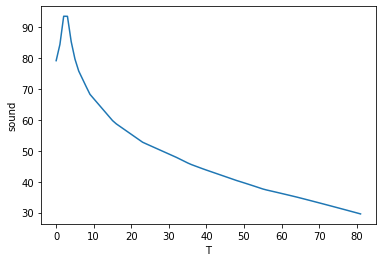

In [ ]:
sns.lineplot(data=df_sample_data_initial2, x='T', y='sound')

Text(0, 0.5, 'Noise Level(dB)')

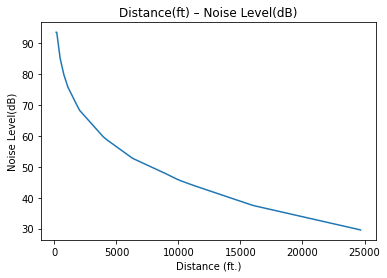

In [ ]:
g1 = sns.lineplot(data=df_sample_data_initial2, x='distance', y='sound')
g1.set(title='Distance(ft) – Noise Level(dB)')
g1.set_xlabel("Distance (ft.)")
g1.set_ylabel("Noise Level(dB)")

## plot check sound-distance

Text(0, 0.5, 'Noise Level(dB)')

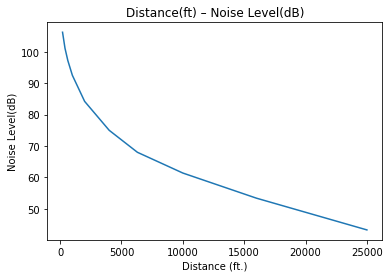

In [ ]:
SD = pd.DataFrame({ "distance": [200, 400, 630, 1000, 2000, 4000, 6300, 10000, 16000, 25000],
                    "sound": [106.2, 101.1, 97.2, 92.5, 84.2, 75.0, 68.0, 61.4, 53.4, 43.3],})

# SD = pd.DataFrame({ "distance": [200, 400, 630, 1000, 2000],
#                     "sound": [106.2, 101.1, 97.2, 92.5, 84.2],})

# # apply normalization techniques
# for column in SD.columns:
#     SD[column] = SD[column]  / SD[column].abs().max()
    
# # apply normalization techniques
# for column in SD.columns:
#     SD[column] = (SD[column] - SD[column].mean()) / SD[column].std()

plot_SD = sns.lineplot(data=SD, x='distance', y='sound')
plot_SD.set(title='Distance(ft) – Noise Level(dB)')
plot_SD.set_xlabel("Distance (ft.)")
plot_SD.set_ylabel("Noise Level(dB)")




In [ ]:

X_train = [200, 400, 630, 1000, 2000, 4000, 6300, 10000, 16000, 25000]
y_train = [106.2, 101.1, 97.2, 92.5, 84.2, 75.0, 68.0, 61.4, 53.4, 43.3]

arr = np.column_stack((X_train, y_train))
arr

array([[  200. ,   106.2],
       [  400. ,   101.1],
       [  630. ,    97.2],
       [ 1000. ,    92.5],
       [ 2000. ,    84.2],
       [ 4000. ,    75. ],
       [ 6300. ,    68. ],
       [10000. ,    61.4],
       [16000. ,    53.4],
       [25000. ,    43.3]])

# Grid

In [ ]:
#----------- Size grid (ALL) -----------#
x = 20
y = 20

In [ ]:
#----------- calculate lat, long (deg) -----------#
Latitude = x/110.574
Longitude = y/(111.320*np.cos(Latitude)) # <----- not sure [Longitude: 1 deg = 111.320*cos(latitude) km]

In [ ]:
Latitude
Longitude

0.18264170885625858

In [ ]:
# 100.6042,13.9133 DMK
# 50 ช่อง -> เพิ่มทีละ 0.004
100.5, 100.7
13.8, 14.0